# Data Preprocessing Notebook

In this notebook, I wanted to prepare a clean and meaningful dataset for my machine learning models.  
My goal in this project is to predict how the NASDAQ-100 index will move in the future using different ML approaches.

Originally, I planned to use a Kaggle dataset that contained daily NASDAQ-100 values. However, I quickly realized that the dataset only had around 15 months of data. This was a big limitation because:

- The dataset was too small for machine learning
- I couldn’t capture long-term market behavior
- There were no major events (like 2008 or COVID) to analyze
- The model would not learn meaningful patterns

Because of these issues, I decided to switch to `yfinance`, which allowed me to download **24+ years** of daily NASDAQ-100 data (from 2000 to 2024). This made the dataset much richer and helped me build a more realistic ML pipeline.

This notebook shows exactly how I downloaded the data, cleaned it, created features, and prepared targets for my models.

## What is the NASDAQ-100?

The NASDAQ-100 is a stock market index that tracks the performance of the 100 largest non-financial companies listed on the NASDAQ exchange.  
In simple words, it represents the biggest technology-focused companies in the US — including Apple, Microsoft, Nvidia, Amazon, Meta, and others.

The index gives a good idea of how the technology sector is moving. Since tech companies drive a big part of the US economy, predicting the NASDAQ-100 can help us understand short-term and long-term market behavior.

I chose this index because:
- It is popular and widely studied
- It has clear financial meaning
- It reacts strongly to market events, making predictions interesting

## Step 1 — Import all required libraries

Here I import the libraries I will use throughout the preprocessing pipeline.
- `yfinance` to download the data
- `pandas` and `numpy` for data manipulation
- `matplotlib` for visualization

Later, I also create simple indicators like moving averages, volatility, and RSI.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

## Step 2 — Download 24+ years of NASDAQ-100 Data

Using `yfinance`, I downloaded the daily prices for the NASDAQ-100 index (^NDX).  
I chose the range from **2000 to 2024** so I could include major events like:

- Dot-com crash (2000–2002)
- 2008 financial crisis
- COVID crash in 2020
- Post-COVID recovery

This gives my models more variety and makes any analysis more meaningful.

In [2]:
nasdaq = yf.download("^NDX", start="2000-01-01", end="2024-12-31")

nasdaq = nasdaq.reset_index()
nasdaq.head()

/var/folders/57/5_c0gzws2kzbkc1_vj90f8v40000gn/T/ipykernel_5286/2140052825.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download("^NDX", start="2000-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NDX,^NDX,^NDX,^NDX,^NDX
0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000
1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000
2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000
3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000
4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000


## Step 3 — Cleaning Column Names

To make the dataset easier to work with, I converted all column names to lowercase and added underscores. This helps avoid typos when referencing columns in later notebooks.

In [5]:
# If yfinance returns a tuple (rare), extract the first element
if isinstance(nasdaq, tuple):
    nasdaq = nasdaq[0]

# If the columns are MultiIndex, flatten them
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = nasdaq.columns.get_level_values(0)
nasdaq = nasdaq.reset_index()

# Clean column names
nasdaq.columns = [str(c).lower().replace(" ", "_") for c in nasdaq.columns]
nasdaq.head()

,index,date,close,high,low,open,volume
0,0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000
1,1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000
2,2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000
3,3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000
4,4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000


## Step 4 — Create Log Returns

Stock prices themselves are not ideal for ML models, so I created log returns.  
In simple words, a **log return** tells me how much the index changed from one day to the next in percentage terms, but in a mathematically cleaner way.

Log returns are useful because they:
- Make the data more stable
- Handle large changes better
- Make time series modeling easier

In [6]:
nasdaq["log_return"] = np.log(nasdaq["close"] / nasdaq["close"].shift(1))
nasdaq.head()

,index,date,close,high,low,open,volume,log_return
0,0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000,NaN
1,1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000,-0.066635
2,2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000,-0.011027
3,3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000,-0.048636
4,4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000,0.054971


## Step 5 — Add Simple Technical Indicators

To help my models capture short-term and medium-term trends, I added a few commonly used indicators:

- **MA5:** 5-day moving average  
- **MA20:** 20-day moving average  
- **Volatility:** 20-day rolling standard deviation  
- **RSI:** A momentum indicator that shows whether the index is overbought or oversold  

I did not add too many features to keep the project simple and easy to explain.

In [7]:
# Moving Averages
nasdaq["ma5"] = nasdaq["close"].rolling(5).mean()
nasdaq["ma20"] = nasdaq["close"].rolling(20).mean()

# Rolling Volatility
nasdaq["volatility"] = nasdaq["log_return"].rolling(20).std()

# RSI Calculation
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

nasdaq["rsi"] = compute_rsi(nasdaq["close"])

## Step 6 — Create Prediction Targets

Since my research question involves predicting both **next-day returns** and **next-week returns**, I created:

- `target_next_day_return`: the log return for the following day  
- `target_next_week_return`: the log return 5 days ahead  
- `target_direction`: a binary label (1 if next-day return > 0, else 0)

These targets will be used in Notebook 2 when training classical and deep learning models.

In [8]:
nasdaq["target_next_day_return"] = nasdaq["log_return"].shift(-1)
nasdaq["target_next_week_return"] = np.log(nasdaq["close"].shift(-5) / nasdaq["close"])
nasdaq["target_direction"] = (nasdaq["target_next_day_return"] > 0).astype(int)

## Step 7 — Drop Missing Rows

Because the moving averages, volatility, RSI, and targets all create NaN values at the start and end of the dataset, I removed rows with missing values.

This gives me a clean dataset ready for modeling.

In [9]:
nasdaq_clean = nasdaq.dropna().reset_index(drop=True)
nasdaq_clean.head()

,index,date,close,high,low,open,volume,log_return,ma5,ma20,volatility,rsi,target_next_day_return,target_next_week_return,target_direction
0,20,2000-02-01,3701.780029,3703.590088,3544.929932,3580.290039,1398240000,0.036234,3586.463965,3628.669995,0.037532,56.083963,0.006108,0.093051,1
1,21,2000-02-02,3724.459961,3785.360107,3693.949951,3700.199951,1527880000,0.006108,3607.113965,3637.582996,0.034236,59.850592,0.033453,0.063456,1
2,22,2000-02-03,3851.159912,3857.340088,3704.229980,3726.129883,1722330000,0.033453,3658.715967,3654.775488,0.034755,59.616737,0.006009,0.060171,1
3,23,2000-02-04,3874.370117,3929.810059,3856.830078,3858.600098,1751450000,0.006009,3744.364014,3681.453491,0.032412,57.226972,0.015106,0.024103,1
4,24,2000-02-07,3933.340088,3933.750000,3858.889893,3873.429932,1625540000,0.015106,3817.022021,3701.640491,0.030503,57.442010,0.032376,0.013332,1


## Step 8 — Quick Visualization

Before modeling, I wanted to visualize the closing price of the NASDAQ-100 over time.  
This helps me understand long-term behavior and ensures the data downloaded correctly.

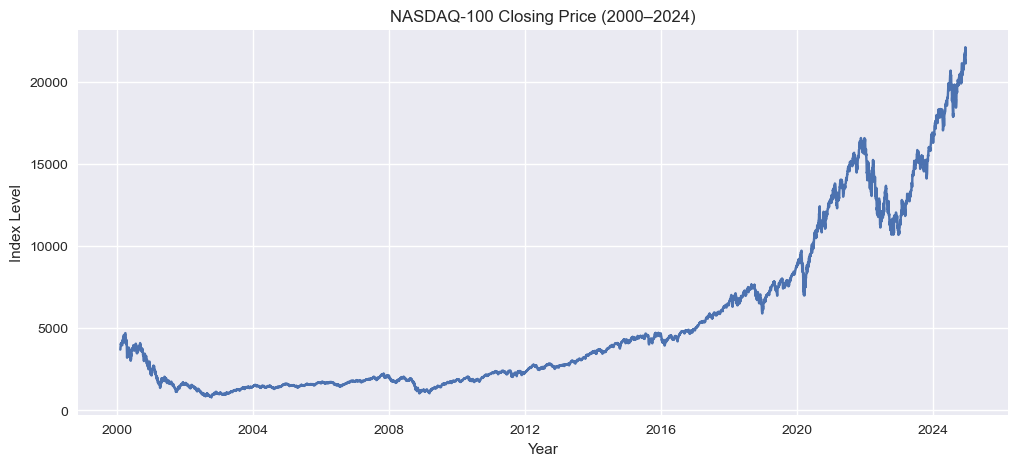

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(nasdaq_clean["date"], nasdaq_clean["close"])
plt.title("NASDAQ-100 Closing Price (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Index Level")
plt.show()

## Step 9 — Save Dataset for Modeling

Finally, I saved the cleaned and feature-engineered dataset into a CSV file.  
This makes Notebook 2 (Model Construction) reproducible and easier to manage.

In [11]:
nasdaq_clean.to_csv("nasdaq_processed.csv", index=False)
nasdaq_clean.shape

(6263, 15)